In [14]:
import h5py
import numpy as np
import pandas as pd
from data_analysis_codes import param
from data_analysis_codes.tools import LinData
from data_analysis_codes.tools import GetVars_Plot2d as GVar
import matplotlib.pyplot as plt
from data_analysis_codes.tools import Cstyle
plt.style.use(Cstyle.style1)

In [2]:
A = np.array([[0,2,4],
              [2,1,2],
              [4,2,2]])
I3 = np.array([[1,0,0],
               [0,1,0],
               [0,0,1]])

In [3]:
w, v = np.linalg.eig(A)
print(w) #eigenvalues
print()
print(v) #eigenvectors

[ 6.54697322 -3.16032332 -0.3866499 ]

[[ 0.56151746  0.80547563  0.18949182]
 [ 0.45229371 -0.10700473 -0.88542667]
 [ 0.69291309 -0.58288849  0.42439659]]


In [4]:
np.sum(np.abs(np.einsum('ab,bc,cd->ad', (A-w[0]*I3), (A-w[1]*I3), (A-w[2]*I3))))

3.375077994860476e-13

In [5]:
A = np.array([[2,2,2],
              [0,0,0],
              [0,0,0]])
B = np.array([[2,0,0],
              [2,0,0],
              [2,0,0]])
np.einsum('ab,bc->ac', A, B)

array([[12,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  0]])

In [6]:
sim128 = param.pflrw_d3e2_L1821_t1_N128_LCDM()
Lin128 = LinData.LinData_Class(sim128, '/home/robynm/simulations/'+sim128.sim_name+'/')
f128 = pd.read_table('/home/robynm/simulations/'+sim128.sim_name+'/h5_data.csv', delimiter=',')
get_var = GVar.Get_var(Lin128, '/home/robynm/simulations/pflrw_d3e2_L1821_t1_N128_LCDM/output-0000/pflrw_L1821/')

 read time file


In [8]:
it = 20000

In [9]:
f = h5py.File('{}_it_{:06d}.hdf5'.format('/home/robynm/simulations/pflrw_d3e2_L1821_t1_N128_LCDM/output-0000/pflrw_L1821/all_iterations/pflrw_d3e2_L1821_t1_N128_LCDM', it), 'r')
invar_dict = get_var.get_the_invar(f, it)

/home/robynm/mycodes/jupiter_notebooks/data_analysis_codes/tools/GetVars_Plot2d.py:169: RuntimeWarning: invalid value encountered in sqrt
  return {'L':L_invar, 'M':M_invar, 'Re(J)':np.real(J_invar), 'Im(J)':np.imag(J_invar), 'Re(I)':np.real(I_invar), 'Im(I)':np.imag(I_invar), 'Re(S)':np.real(S_invar), 'Im(S)':np.imag(S_invar), '|E|':np.sqrt(Edict['E2']), '|B|':np.sqrt(Bdict['B2']), 'Edown':Edict['Edown'], 'Bdown':Bdict['Bdown']}


In [11]:
def take_diag(data):
    return np.array([abs(data[:, j, j]) for j in range(Lin128.N)])

2.7430314963883262e-17


Text(0.5, 0, 'x$\\;\\;[\\lambda_{pert}]$')

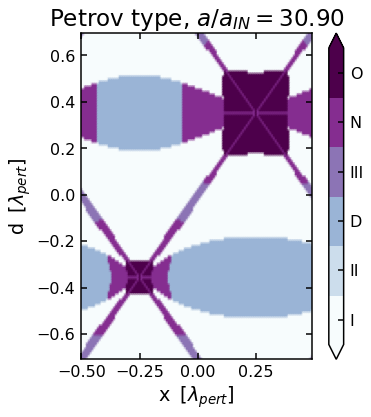

In [58]:
H = Lin128.temp_from_temp('H', 'it', it)
dE = take_diag(invar_dict['|E|'])/H**2
dB = take_diag(invar_dict['|B|'])/H**2
dS = take_diag(invar_dict['Re(S)'])
dI = take_diag(invar_dict['Re(I)'])/H**4
dJ = take_diag(invar_dict['Re(J)'])/H**6
dL = take_diag(invar_dict['L'])/H**4

Qdown = invar_dict['Edown']+1j*invar_dict['Bdown']
psi2 = -Qdown[2,2]/2
psi3 = -(Qdown[0,2]+1j*Qdown[1,2])/2
psi1 = Qdown[0,2]+psi3
psi0 = -Qdown[0,0]+psi2+1j*Qdown[0,1]
psi4 = psi0-2j*Qdown[0,1]

K = psi1*psi4*psi4-3*psi4*psi3*psi2+2*psi3**2
L = psi2*psi4-psi3**2
I = invar_dict['Re(I)']+1j*invar_dict['Im(I)']
N = 12*L**2-psi4*psi4*I

dK = take_diag(K)/H**6
dL = take_diag(L)/H**4
dN = take_diag(N)/H**8

Petrov_class = np.copy(dS)
cutoff = 1e-1
for i in range(np.shape(dS)[0]):
    for j in range(np.shape(dS)[1]):
        if dE[i,j]<cutoff and dB[i,j]<cutoff:
            Petrov_class[i,j]=6 #type O
        else:
            if abs(dS[i,j]-1)<cutoff:
                if dI[i,j]<cutoff and dJ[i,j]<cutoff:
                    if dK[i,j]<cutoff and dL[i,j]<cutoff:
                        Petrov_class[i,j]=5 #type N
                    else:
                        Petrov_class[i,j]=4 #type III
                else:
                    if dK[i,j]<cutoff and dN[i,j]<cutoff:
                        Petrov_class[i,j]=3 #type D
                    else:
                        Petrov_class[i,j]=2 #type II
            else:
                Petrov_class[i,j]=1 #type I
print(diagmax)
fig, ax = plt.subplots(figsize=(6,6))
cmap = plt.cm.get_cmap('BuPu', 6)
plt.pcolormesh(Lin128.d3xyz/sim128.L, Lin128.d3xyz*np.sqrt(2)/sim128.L, Petrov_class, cmap=cmap, vmin=0.5, vmax=6.5, shading='gouraud')
plt.gca().set_aspect("equal")
cbar = plt.colorbar(extend='both', ticks=[1, 2, 3, 4, 5, 6])
cbar.ax.set_yticklabels(['I', 'II', 'D', 'III', 'N', 'O'])
plt.title('Petrov type, '+r'$a/a_{IN}=$'+'{:.2f}'.format(Lin128.temp_from_temp('an', 'it', it)))
plt.ylabel('d'+r'$\;\;[\lambda_{pert}]$')
plt.xlabel('x'+r'$\;\;[\lambda_{pert}]$')

In [29]:
print(np.einsum('ab,bc->ac', dQ[:,:,i,j], dQ[:,:,i,j]))
print()
print(np.sum(abs(np.einsum('ab,bc,cd->ad', dQ[:,:,i,j], dQ[:,:,i,j], dQ[:,:,i,j]))))

[[-1.55233293e-07+5.86906907e-08j -8.34922932e-07+6.07794738e-08j
  -3.11246196e-06+2.40465091e-07j]
 [ 1.06949777e-06-2.14648919e-07j -6.21489376e-07+2.62906960e-07j
   1.26715095e-06-1.68008591e-07j]
 [-5.06258410e-07+1.03286840e-07j -6.25798584e-07+1.97356700e-07j
   1.58535653e-06-1.83107013e-07j]]

9.687120026090601e-09


In [31]:
abs(np.real(-1.55233293e-07+5.86906907e-08j))

1.55233293e-07